<a href="https://colab.research.google.com/github/hyd3nekosuki/UQExercise/blob/main/UQExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 不確かさ評価の例題

In [1]:
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
from numba import njit

入力変数$x,y$に対して、出力$z$が関数$z=f(x,y)$で表されるとする。

In [2]:
@njit(cache=True)
def modelFunction(x,y):
   return 2*x**2 - 3*y

2つの入力変数$x,y$の平均$\mu_x, \mu_y$、および共分散行列$\mathbf{\Sigma}$を設定する。

In [3]:
xave = 1.0  # mean of x
ux = 0.5    # standard deviation of x
yave = 4.0  # mean of y
uy = 2.0    # standard deviation of y
rho = 0.5   # correlation between x and y

ave = np.array( [xave, yave] )
cov = np.array([[ux**2, ux*uy*rho], [uy*ux*rho, uy**2]])

## サンドイッチ則に基づいた不確かさ伝播による出力$z$の不確かさ評価

$$ \sigma_{z} \approx \mathbf{S} \mathbf{\Sigma} \mathbf{S}^T $$

In [4]:
# Sandwich formula
# evaluation of sensitivity matrix using numerical differentiation
eps = 1e-5
dzdx = (modelFunction(xave*(1+eps), yave) - modelFunction(xave*(1-eps), yave))/(2*eps*xave)
dzdy = (modelFunction(xave, yave*(1+eps)) - modelFunction(xave, yave*(1-eps)))/(2*eps*yave)

S = np.array([dzdx, dzdy]).reshape( (1, len(ave)) )

zbar = modelFunction(xave, yave) 
uz = np.sqrt( (S.dot(cov)).dot(S.T) )[0,0]
print("z = {0} ± {1}".format(zbar, uz))

z = -10.0 ± 5.291502622121884


## Unscented変換に基づいた決定論的サンプリングによる出力$z$の不確かさ評価

In [5]:
# UT sampling
# check the rank of covariance matrix
r = np.linalg.matrix_rank(cov)
n=2*r+1
# kappa = 0.5
kappa = 3.0 - r

# SVD
U, s, V =  np.linalg.svd(cov, full_matrices=False)
# square root of covariance matrix
A = U.dot( np.diag ( np.sqrt(s) ) )

X = np.zeros((n, len(ave)))
weight = np.zeros(n)
factor = np.sqrt(r+kappa)
X[0,:] = ave
for i in range(r):
    ip = 2*i+1
    im = 2*i+2
        
    X[ip,:] = ave + factor*A[:,i]
    X[im,:] = ave - factor*A[:,i]
    weight[ip]   = 1/(2*(r+kappa))
    weight[im]   = 1/(2*(r+kappa))
weight[0] = 1.0 - weight.sum()

"""
aveUT = np.zeros( len(ave) )
for i in range(n):
    aveUT += weight[i] *(X[i,:])
print(aveUT)

covUT = np.zeros_like(cov)
for i in range(n):
    sigma = (X[i,:] - aveUT).reshape((1,len(ave)))
    covUT += weight[i] * sigma.T.dot(sigma)
print(covUT)
"""

z = modelFunction(X[:,0], X[:,1])
zaveUT = 0.0
for i in range(n):
    zaveUT += weight[i]*z[i]

uzUT = 0.0
for i in range(n):
    sigma = (z[i] - zaveUT)
    uzUT += weight[i] * sigma**2
uzUT = np.sqrt(uzUT)
print("z = {0} ± {1}".format(zaveUT, uzUT))

z = -9.5 ± 5.310484423598097


## ランダムサンプリング法による出力$z$の不確かさ評価

In [6]:
@njit(cache=True)
def randomMultivariateNormalSVD(ave, cov, n=None):
    if n is None:
        n=1
    xi = np.random.randn(n, len(ave))
    U, s, V =  np.linalg.svd(cov, full_matrices=False)
    S = np.diag ( np.sqrt(s) )
    A = U.dot(S)
    X = ave + np.dot(xi, A.T)
    return X

z = -9.492445151976728 ± 5.387244265074252


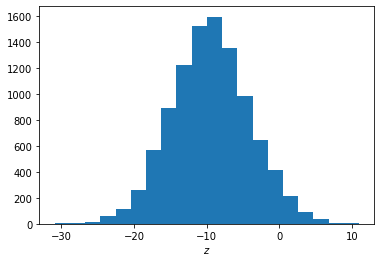

In [7]:
# random sampling
n = 10000
X = randomMultivariateNormalSVD(ave, cov, 10000)

z = modelFunction(X[:,0], X[:,1])
zaveRS = z.mean()
uzRS = z.std(ddof=1)
print("z = {0} ± {1}".format(zaveRS, uzRS))
plt.hist(z, bins=20)
plt.xlabel("$z$")
plt.show()